# 数据预处理


在模型训练过程中有时会遇到过拟合的问题，其中一个解决方法就是对训练数据做数据增强处理。通过对数据进行特定的处理，如图像的裁剪、翻转、调整亮度等处理，以增加样本的多样性，从而增强模型的泛化能力。

本节以图像数据为例，介绍数据预处理的方法。


## 一、paddle.vision.transforms 介绍

飞桨框架在 [paddle.vision.transforms](../../api/paddle/vision/Overview_cn.html#about-transforms) 下内置了数十种图像数据处理方法，可以通过以下代码查看：

In [1]:
import paddle
print('图像数据处理方法：', paddle.vision.transforms.__all__)

图像数据处理方法： ['BaseTransform', 'Compose', 'Resize', 'RandomResizedCrop', 'CenterCrop', 'RandomHorizontalFlip', 'RandomVerticalFlip', 'Transpose', 'Normalize', 'BrightnessTransform', 'SaturationTransform', 'ContrastTransform', 'HueTransform', 'ColorJitter', 'RandomCrop', 'Pad', 'RandomRotation', 'Grayscale', 'ToTensor', 'to_tensor', 'hflip', 'vflip', 'resize', 'pad', 'rotate', 'to_grayscale', 'crop', 'center_crop', 'adjust_brightness', 'adjust_contrast', 'adjust_hue', 'normalize']


包括图像随机裁剪、图像旋转变换、改变图像亮度、改变图像对比度等常见操作，各个操作方法的简介可参考 [API 文档](../../api/paddle/vision/Overview_cn.html#about-transforms)。



对于飞桨框架内置的数据预处理方法，可以单个调用，也可以将多个数据预处理方法进行组合使用，具体使用方式如下：

* 单个使用

In [2]:
from paddle.vision.transforms import Resize

# 定义一个待使用的数据处理方法，这里定义了一个调整图像大小的方法
transform = Resize(size=28)

* 多个组合使用

这种使用模式下，需要先定义好每个数据处理方法，然后用`Compose` 进行组合。

In [3]:
from paddle.vision.transforms import Compose, RandomRotation

# 定义待使用的数据处理方法，这里包括随机旋转、改变图片大小两个组合处理
transform = Compose([RandomRotation(10), Resize(size=32)])

## 二、在数据集中应用数据预处理操作

定义好数据处理方法后，可以直接在数据集 Dataset 中应用，下面介绍两种数据预处理应用方式：一种是在框架内置数据集中应用，一种是在自定义的数据集中应用。

### 2.1 在框架内置数据集中应用

前面已定义好数据处理的方法，在加载内置数据集时，将其传递给 `transform` 字段即可。


In [4]:
# 通过 transform 字段传递定义好的数据处理方法，即可完成对框架内置数据集的增强
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)

### 2.2 在自定义的数据集中应用

对于自定义的数据集，可以在数据集中将定义好的数据处理方法传入 `__init__` 函数，将其定义为自定义数据集类的一个属性，然后在 `__getitem__` 中将其应用到图像上，如下述代码所示：

In [ ]:
# 下载 MNIST 数据集并解压
! wget https://paddle-imagenet-models-name.bj.bcebos.com/data/mnist.tar
! tar -xf mnist.tar

In [12]:
import os
import cv2
import numpy as np
from paddle.io import Dataset

class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """
    def __init__(self, data_dir, label_path, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super(MyDataset, self).__init__()
        self.data_list = []
        with open(label_path,encoding='utf-8') as f:
            for line in f.readlines():
                image_path, label = line.strip().split('\t')
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
        # 2. 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        image_path, label = self.data_list[index]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = image.astype('float32')
        # 3. 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        label = int(label)
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data_list)
# 1. 定义随机旋转和改变图片大小的数据处理方法
transform = Compose([RandomRotation(10), Resize(size=32)])

custom_dataset = MyDataset('mnist/train','mnist/train/label.txt', transform)

在以上示例代码中，定义了随机旋转和改变图片大小数据处理方法，并传入 `__init__` 函数，然后在 `__getitem__` 中将其应用到图像上。

## 三、数据预处理的几种方法介绍

通过可视化的方法，可方便地对比飞桨内置数据处理方法的效果，下面介绍其中几个方法的对比示例。

首先下载示例图片

In [ ]:
# 下载示例图片
! wget https://paddle-imagenet-models-name.bj.bcebos.com/data/demo_images/flower_demo.png

### CenterCrop:

对输入图像进行裁剪，保持图片中心点不变。

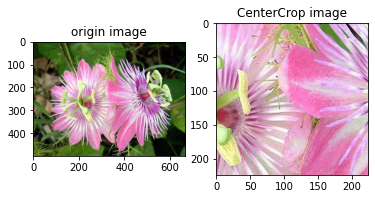

In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from paddle.vision.transforms import CenterCrop

transform = CenterCrop(224)

image = cv2.imread('flower_demo.png')

image_after_transform = transform(image)
plt.subplot(1,2,1)
plt.title('origin image')
plt.imshow(image[:,:,::-1])
plt.subplot(1,2,2)
plt.title('CenterCrop image')
plt.imshow(image_after_transform[:,:,::-1])

### RandomHorizontalFlip

基于概率来执行图片的水平翻转。

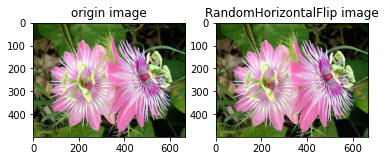

In [2]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from paddle.vision.transforms import RandomHorizontalFlip

transform = RandomHorizontalFlip(0.5)

image = cv2.imread('flower_demo.png')

image_after_transform = transform(image)
plt.subplot(1,2,1)
plt.title('origin image')
plt.imshow(image[:,:,::-1])
plt.subplot(1,2,2)
plt.title('RandomHorizontalFlip image')
plt.imshow(image_after_transform[:,:,::-1])

### ColorJitter

随机调整图像的亮度、对比度、饱和度和色调。

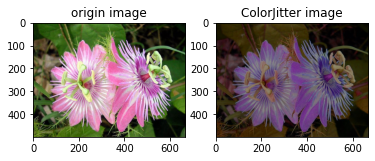

In [3]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from paddle.vision.transforms import ColorJitter

transform = ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)

image = cv2.imread('flower_demo.png')

image_after_transform = transform(image)
plt.subplot(1,2,1)
plt.title('origin image')
plt.imshow(image[:,:,::-1])
plt.subplot(1,2,2)
plt.title('ColorJitter image')
plt.imshow(image_after_transform[:,:,::-1])

更多数据处理方法介绍可以参考  [paddle.vision.transforms API 文档](../../api/paddle/vision/Overview_cn.html#about-transforms)。

## 四、总结

本节介绍了数据预处理方法在数据集中的使用方式，可先将一个或多个方法组合定义到一个实例中，再在数据集中应用，总结整个流程和用到的关键 API 如下图所示。

![](images/data_preprocessing.png)

图 1：数据预处理流程


图像、文本等不同类型的数据预处理方法不同，关于文本的数据预处理可以参考 [NLP 应用实践](../../practices/nlp/index_cn.html)。